# Train Binary Classifier using AutoGluon

AutoGluon은 `fit()` 함수 호출만으로 상당히 높은 정확도의 모델을 생성하며, 최신 기능들을 계속 업데이트되고 있습니다. <br>
본 핸즈온에서는 개인 소득이 $50k를 초과하는지 여부를 예측하는 이진 분류 모델을 AutoGluon으로 훈련해 보겠습니다.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
torch.__version__

'1.10.0'

## 1. Quick Start

Toy example로 AutoGluon의 저장소에 있는 CSV 데이터셋을 로드하고, 핸즈온을 위해 500건의 데이터만 샘플링합니다.

참고로 TabularDataset은 pandas 데이터프레임과 호환되기 때문에, TabularDataset을 데이터프레임으로 변환하거나 데이터프레임을 TabularDataset로 자유롭게 변환할 수 있습니다.

### Data preparation

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')

subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)

label = 'class'
print("Summary of class variable: \n", train_data[label].describe())

y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(columns=[label])  # delete label column to prove we're not cheating

Summary of class variable: 
 count        500
unique         2
top        <=50K
freq         365
Name: class, dtype: object


In [3]:
train_data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
6118,51,Private,39264,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K
23204,58,Private,51662,10th,6,Married-civ-spouse,Other-service,Wife,White,Female,0,0,8,United-States,<=50K
29590,40,Private,326310,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,<=50K
18116,37,Private,222450,HS-grad,9,Never-married,Sales,Not-in-family,White,Male,0,2339,40,El-Salvador,<=50K
33964,62,Private,109190,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,40,United-States,>50K


### Training

여러분은 단 한 줄의 코드로 쉽게 AutoML을 수행할 수 있습니다.
문제 유형을 지정하지 않아도 자동으로 문제 유형을 파악하며, 별도의 피쳐 인코딩/변환을 수행하지 않아도 되며 결측치 또한 자동으로 처리할 수 있습니다.
이 때, 별도의 검증 데이터셋을 지정하지 않으면, AutoGluon은 데이터의 자동으로 훈련 데이터/검증 데이터를 분리합니다.

AutoGluon은 검증 데이터에서 최고의 성능을 내기 위한 다양한 조합을 반복적으로 수행하며, `fit()`에서 다양한 인수를 지정하여 자유롭게 AutoML을 수행할 수 있습니다.

참고로, Titanic 데이터셋에 아래 설정으로 훈련 수행 시 Kaggle Private LB 기준으로 Top 3%의 accuracy를 보입니다.
(https://www.kaggle.com/innixma/top-3-in-1-line-of-code-w-autogluon)
```python
# Titanic Top 3% accuracy
predictor = TabularPredictor(label=label).fit(train_data, time_limit=3600, num_bag_folds=8)
```

#### Tip 
GPU가 있다면, AutoGluon 0.1부터 LightGBM, CatBoost, XGBoost, NN, FastAI NN 모델 훈련 시 GPU로 훈련이 가능합니다.
```python
predictor = TabularPredictor(..).fit(..., ag_args_fit={'num_gpus': 1})
```

In [4]:
!rm -rf ag-01-binary ag-01-binary-hpo

In [5]:
# time_limit=60 -> 60sec = 1min
save_path = 'ag-01-binary'
predictor = TabularPredictor(label=label, path=save_path).fit(train_data, time_limit=60)

Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "ag-01-binary/"
AutoGluon Version:  0.5.2
Python Version:     3.8.12
Operating System:   Linux
Train Data Rows:    500
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' >50K', ' <=50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fit

### Evaluation

In [6]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('category', [])  : 7 | ['workclass', 'education', 'marital-status', 'occupation', 'relationship', ...]
('int', [])       : 6 | ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', ...]
('int', ['bool']) : 1 | ['sex']


In [7]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: class, dtype: object

In [8]:
y_prob = predictor.predict_proba(test_data_nolab)
y_prob.head()

,<=50K,>50K
0,0.982107,0.017893
1,0.988337,0.011663
2,0.573505,0.426495
3,0.998272,0.001728
4,0.990299,0.009701


In [9]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.8374449790152523
Evaluations on test data:
{
    "accuracy": 0.8374449790152523,
    "balanced_accuracy": 0.7430558394221018,
    "mcc": 0.5243657567117436,
    "f1": 0.621904761904762,
    "precision": 0.69394261424017,
    "recall": 0.5634167385677308
}


ROC 커브, Precision-Recall 커브, Confusion matrix를 확인합니다. 

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      7451
           1       0.69      0.56      0.62      2318

    accuracy                           0.84      9769
   macro avg       0.78      0.74      0.76      9769
weighted avg       0.83      0.84      0.83      9769



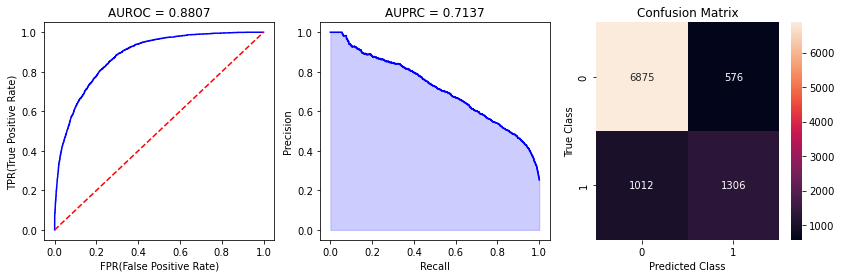

In [10]:
from src.utils import plot_all
y_prob = predictor.predict_proba(test_data_nolab)
y_prob_ = y_prob.iloc[:,-1]
plot_all(y_test, y_prob_)

In [11]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost       0.87       0.044890  0.442614                0.044890           0.442614            1       True         11
1   WeightedEnsemble_L2       0.87       0.045413  0.770176                0.000522           0.327562            2       True         14
2              CatBoost       0.85       0.010740  1.317234                0.010740           1.317234            1       True          7
3              LightGBM       0.85       0.014454  0.265227                0.014454           0.265227            1       True          4
4        NeuralNetTorch       0.85       0.018401  2.496524                0.018401           2.496524            1       True         12
5      RandomForestGini       0.84       0.066613  0.629995                0.066613           0.629995        

In [12]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.87,0.044890,0.442614,0.044890,0.442614,1,True,11
1,WeightedEnsemble_L2,0.87,0.045413,0.770176,0.000522,0.327562,2,True,14
2,CatBoost,0.85,0.010740,1.317234,0.010740,1.317234,1,True,7
3,LightGBM,0.85,0.014454,0.265227,0.014454,0.265227,1,True,4
4,NeuralNetTorch,0.85,0.018401,2.496524,0.018401,2.496524,1,True,12
5,RandomForestGini,0.84,0.066613,0.629995,0.066613,0.629995,1,True,5
6,LightGBMLarge,0.83,0.017587,0.553040,0.017587,0.553040,1,True,13
7,LightGBMXT,0.83,0.018786,0.893909,0.018786,0.893909,1,True,3
8,RandomForestEntr,0.83,0.071608,0.549277,0.071608,0.549277,1,True,6
9,NeuralNetFastAI,0.82,0.017581,1.669663,0.017581,1.669663,1,True,10


<br>

## 2. Hyperparameter Tuning

`fit()`은 기본적으로 신경망과 다양한 유형의 트리 앙상블 모델을 훈련합니다. 각 모델 유형에 대해 다양한 하이퍼파라메터를 지정할 수 있으며, 각 하이퍼 파라미터에 대해 단일 고정 값을 지정하거나 고려할 하이퍼파라메터의 검색 공간(search space)을 지정할 수 있습니다. 지정하지 않은 하이퍼 파라미터는 AutoGluon에서 자동으로 선택한 기본 설정으로 유지됩니다. 또한, 특정 모델을 훈련 시 제외할 수 있습니다.

아래 코드 셀에서는 NN(Neural Network), GBM(Gradient Boosted Tree) 모델에 대해 아래의 하이퍼파라메터 조합을 설정하여 훈련을 수행하면서,
RF(Random Forest), XT(ExtraTress)를 제외하는 예시를 보여주고 있습니다.


### Pre-defined presets

AutoGluon은 사전 정의된 6종류의 프리셋을 지원하고 있으며, 각 프리셋 설정에 적합한 하이퍼파라메터 튜닝이 자동으로 수행됩니다.
- `best_quality`
- `best_quality_with_high_quality_refit`
- `high_quality_fast_inference_only_refit`
- `good_quality_faster_inference_only_refit`
- `medium_quality_faster_train`
- `optimize_for_deployment`

best_quality의 성능이 가장 높지만, 훈련 시간이 오래 걸리고 스태킹(stacking)을 위한 디스크 공간을 많이 차지하므로, 상황에 따라 적절한 프리셋을 선택하세요.

In [13]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 5,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hparams = {  # hyperparameters of each model type
    'GBM': gbm_options,
    'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
}  # When these keys are missing from hyperparameters dict, no models of that type are trained


In [14]:
time_limit = 2*60  # train various models for ~2 min
metric = 'accuracy'
save_path = 'ag-01-binary-hpo'
verbosity = 0

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path, verbosity=verbosity).fit(
    train_data, 
    #tuning_data=val_data, 
    time_limit=time_limit,
    hyperparameters=hparams, 
    hyperparameter_tune_kwargs='auto',
    excluded_model_types=['RF', 'XT']
)

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf fou

In [15]:
y_pred = predictor.predict(test_data_nolab)
y_pred.head()

0     <=50K
1     <=50K
2      >50K
3     <=50K
4     <=50K
Name: class, dtype: object

앞 섹션보다 예측 성능이 더 좋습니다. 다만, 하이퍼파라메터 튜닝을 너무 신봉하지는 마세요. 현업에서는 데이터 전처리가 훨씬 중요합니다!

In [16]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM/T188,0.88,0.016668,0.184702,0.016668,0.184702,1,True,188
1,WeightedEnsemble_L2,0.88,0.017195,0.478697,0.000528,0.293995,2,True,540
2,LightGBM/T90,0.87,0.005122,0.163131,0.005122,0.163131,1,True,90
3,LightGBM/T128,0.87,0.005203,0.198001,0.005203,0.198001,1,True,128
4,LightGBM/T118,0.87,0.005240,0.180823,0.005240,0.180823,1,True,118
...,...,...,...,...,...,...,...,...,...
535,LightGBM/T154,0.73,0.005116,0.165851,0.005116,0.165851,1,True,154
536,LightGBM/T245,0.73,0.013602,0.161725,0.013602,0.161725,1,True,245
537,NeuralNetTorch/56a57220,0.73,0.020064,0.335274,0.020064,0.335274,1,True,301
538,NeuralNetTorch/562f04dc,0.73,0.021745,0.330955,0.021745,0.330955,1,True,297


In [17]:
#predictor.delete_models(models_to_keep=[], dry_run=False)

<br>

## 3. Model Distillation

단일 모델은 일반적으로 weighted/stacked/bagged 앙상블 모델보다 정확도가 낮습니다. 이 때, distillation(증류) 기법을 사용해서 단일 모델의 계산 이점을 유지하면서 앙상블의 성능을 유지할 수 있습니다. 아이디어는 매우 간단하며, 앙상블 모델을 teacher 모델로 하여 teacher 모델의 logit 예측값을 단일 student 모델의 예측값 분포와 유사하게 훈련합니다.

In [18]:
student_models = predictor.distill(time_limit=30)  # specify much longer time limit in real applications
print(student_models)

['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForestMSE_DSTL', 'WeightedEnsemble_L2_DSTL']


In [19]:
preds_student = predictor.predict(test_data_nolab, model=student_models[0])
print(f"predictions from {student_models[0]}:", list(preds_student)[:5])

predictions from LightGBM_DSTL: [' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K']
